In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Data Preprocessing

Time series data can vary wildly in scale, especially when dealing with metrics like prices, energy, or temperature. To avoid high values overwhelming the model, normalization is key.

In [2]:
class TimeSeriesData:
    """
    Dataset class for time series data.
    Parameters:
        ticker (str): stock ticker symbol
        start_date (str): start date for data retrieval
        end_date (str): end date for data retrieval
        look_back (int): number of previous time steps to include in each sample
        train_size (float): proportion of data to use for training
        scaler (string): 'std' StandardScaler, 'minmax' MinMax
    """

    def __init__(self, start_date, end_date, look_back=1, train_size=0.67, scaler='std') -> None:
        self.start_date= start_date
        self.end_date= end_date
        self.look_back= look_back
        self.train_size= train_size
        self.scaler= scaler


    def minmax_scaler(self, train, test, eps=1e-7):
        """
        Min-max scaling of the data.
        Parameters:
            train (np.ndarray): training data
            test (np.ndarray): testing data
        """

        tr_min= np.min(train, 0)
        tr_max= np.max(train, 0)

        # normalizing the training data
        scaled_train= (train - tr_min) / (tr_max - tr_min)
        # normalizing the test data based on statistics from training data
        scaled_test= (test - tr_min) / (tr_max - tr_min)

        return scaled_train, scaled_test


    def std_scaler(self, train, test):
        """
        Scaling with StandardScaler.
        Parameters:
            train (np.ndarray): training data
            test (np.ndarray): testing data
        """

        scaler= StandardScaler()

        scaled_train= scaler.fit_transform(train)
        scaled_test = scaler.transform(test)

        return scaled_train, scaled_test


    def load_data(self, path):
        """
        Load stock data.
        Returns:
            np.ndarray, training data
            np.ndarray, testing data
        """

        df= pd.read_csv(path)
        df= df[(df['Date']>= self.start_date) & (df['Date'] <= self.end_date)]
        df= df.set_index('Date')
        df= df.sort_index()
        df= df.loc[self.start_date:self.end_date]
        df= df[['Close']].astype(float) # use closing price
        df= df.values                   # convert DataFrame to np.array

        train_size= int(len(df) * self.train_size)
        if self.scaler== 'std':
            train, test= self.std_scaler(df[0:train_size,:], df[train_size:len(df),:])
        else:
            train, test= self.minmax_scaler(df[0:train_size,:], df[train_size:len(df),:])

        return train, test


    def create_dataset(self, data):
        """
        Create the dataset for time series prediction.
        Parameters:
            data (np.ndarray) input data
        Returns:
            np.ndarray, input data
            np.ndarray, output data
        """

        Xds, Yds= [], []
        for i in range(len(data)-self.look_back):
            feature= data[i : i+self.look_back]
            target= data[i+1 : i+self.look_back+1]
            Xds.append(feature)
            Yds.append(target)

        return np.array(Xds), np.array(Yds)


    def split_train_test(self, path):
        """
        Get the training and testing data.
        Returns:
            np.ndarray, training input
            np.ndarray, training output
            np.ndarray, testing input
            np.ndarray, testing output
        """

        train, test= self.load_data(path)
        Xtr, Ytr= self.create_dataset(train)
        Xte, Yte= self.create_dataset(test)

        return Xtr, Ytr, Xte, Yte


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
PATH= '/content/drive/My Drive/Colab Notebooks/data/Google_Stock_Train_2010_2022.csv'

Mounted at /content/drive/


In [ ]:
# instantiate the dataset
data= TimeSeriesData('2010-1-1', '2020-12-31', look_back=1)
Xtr, Ytr, Xte, Yte= data.split_train_test(PATH)

# reshape input to be [samples, time steps, features]
Xtr= np.reshape(Xtr, (Xtr.shape[0], Xtr.shape[1], 1))
Xte= np.reshape(Xte, (Xte.shape[0], Xte.shape[1], 1))

This reshaping step adjusts the data format to what the LSTM expects. LSTMs require input to be in the shape of [samples, time steps, features]. Here:

- samples - the number of data points.
- time steps - the number of time steps per sample (look_back).
- features - the number of features per time step (in this case, 1, because we are probably looking at one dimension of data like closing price).

With look_back=1, it is quite surely that the accuracy would not be good for too little clues to predict. But this is a good example to demonstrate the structure of the LSTM model.

# Utility classes

In [ ]:
class WeightInitializer:
    """
    WeightInitializer is a class that handles the initialization of weights. This is crucial as
    different initialization methods can significantly affect the convergence behavior of an NN.
    """

    def __init__(self, method='random') -> None:
        self.method= method


    def initialize(self, shape):
        if self.method== 'random':
            return np.random.randn(*shape)
        elif self.method== 'xavier':
            return np.random.randn(*shape) / np.sqrt(shape[0])
        elif self.method== 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        elif self.method== 'uniform':
            return np.random.uniform(-1, 1, shape)
        else:
            raise ValueError(f'Unknown initialization method: {self.method}')


In [4]:
class PlotManager:
    """
    Utility class for managing plots.
    """

    def __init__(self) -> None:
        self.fig, self.ax= plt.subplots(figsize=(6, 4))


    def plot_losses(self, train_losses, val_losses):
        self.ax.plot(train_losses, label='Training Loss')
        self.ax.plot(val_losses, label='Validation Loss')
        self.ax.set_title('Training and Validation Losses')
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()


    def show_plots(self):
        plt.tight_layout()


In [5]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve.
    Args:
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If true, prints a message for each epoch where the loss does not improve.
        delta (float): Minimum change in the mentioned quantity to quantify as an improvement.
    """

    def __init__(self, patience=7, delta=0, verbose=False) -> None:
        self.patience= patience
        self.delta= delta
        self.verbose= verbose
        self.counter= 0
        self.best_score= None
        self.early_stop= False


    def __call__(self, val_loss):
        """
        Determines if the model should stop training.
        Args:
            val_loss (float): The loss of the model on the validation set.
        """

        score= -val_loss

        if self.best_score is None:
            self.best_score= score
        elif score< self.best_score + self.delta:
            self.counter += 1

            if self.counter >= self.patience:
                self.early_stop= True
        else:
            self.best_score= score
            self.counter= 0


# The LSTM Class

An LSTM cell contains four main components that work together to update and maintain the cell state: the forget gate $f_t$, input gate $i_t$, cell state $C_t$, and output gate $o_t$. Here's how each component is calculated at time step t:

**Forget Gate $f_t$**, this gate decides which parts of the previous cell state $C_{(t-1)}$ are to be forgotten
$$ f_t=\sigma(W_f ⋅ [h_{t-1}, x_t] + b_f)$$
Where:
- $\sigma$ is the sigmoid function, which outputs a value between 0 and 1. This value multiplies the previous cell state $C_(t-1)$, effectively deciding the extent to which each component of the cell state is remembered or forgotten. A value close to 0 means "forget it almost completely," while a value close to 1 means "retain it entirely."
- $W_f$ is the weight matrix for the forget gate.
- $h_{(t-1)}$ is the output from the previous time step.
- $x_t$ is the current input.
- $b_f$ is the bias term for the forget gate.

**Input Gate $i_t$ and Candidate Cell State $C_t$**, the input gate determines which values will be updated in the cell state, while the candidate cell state $C_t$ represents a filtered version of the input data, prepared to be potentially added to the actual cell state.
$$ i_t=\sigma(W_i ⋅ [h_{t-1}, x_t] + b_i$$
$$ \tilde{C}_t = tanh(W_C \cdot [h_{t-1}, x_t] + b_C $$

Where:
- $\sigma$ again represents the sigmoid function, controlling the input gate.
- tanh is the hyperbolic tangent function, which outputs values between -1 and 1. It helps regulate the network's non-linear characteristics.
- $W_i$ and $W_C$ are the weight matrices for the input gate and the candidate cell state, respectively.
- $b_i$ and $b_C$ are the biases for the input gate and the candidate cell state.

**Cell State Update $C_t$**, the cell state is an element-wise addition of the old state multiplied by the forget gate and the candidate state multiplied by the input gate.
$$C_t=f_t * C_{t-1} + i_t * \tilde{C}_t$$

The previous cell state $C_(t-1)$ multiplied by the forget gate output $f_t$ determines how much the old state can retain. The candidate cell state $C_t$ multiplied by the input gate output $i_t$ determines how much of the new state to add.

**Output Gate $o_t$ and Output $h_t$**, finally, the output gate controls the parts of the cell state that are output to the next layer or used in the final prediction.
$$ o_t=\sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $$
$$ h_t=o_t * tanh(C_t) $$

Where:
- $\sigma$ is the sigmoid function used for the output gate.
- tanh applied to $C_t$ scales the cell state values to be between -1 and 1.
- $W_o$ is the weight matrix for the output gate, and $b_o$ is the bias.

In [ ]:
class LSTM:
    """
    Long Short-Term Memory (LSTM) network.
    Parameters:
        input_size (int): dimensionality of input space
        hidden_size (int): number of LSTM units
        output_size (int): dimensionality of output space
        init_method (str): weight initialization method (default: 'xavier')
    """

    def __init__(self, input_size, hidden_size, output_size, init_method='xavier') -> None:
        self.input_size= input_size
        self.hidden_size= hidden_size
        self.output_size= output_size
        self.init= WeightInitializer(method=init_method)

        # initialize weights
        self.wf= self.init.initialize((hidden_size, hidden_size + input_size))
        self.wi= self.init.initialize((hidden_size, hidden_size + input_size))
        self.wo= self.init.initialize((hidden_size, hidden_size + input_size))
        self.wc= self.init.initialize((hidden_size, hidden_size + input_size))
        """
        The weights are initialized for the gates (forget wf, input wi, output wo, and cell wc) and
        for connecting the last hidden state to the output (why).
        Xavier initialization is often chosen as it's a good default for maintaining the variance
        of activations across layers.
        """

        # initialize biases
        self.bf= np.zeros((hidden_size, 1))
        self.bi= np.zeros((hidden_size, 1))
        self.bo= np.zeros((hidden_size, 1))
        self.bc= np.zeros((hidden_size, 1))
        """
        Biases for all gates and the output layer are initialized to zero. This is a common
        practice, although sometimes small constants are added to avoid dead neurons at the start.
        """

        # initialize output layer weights and biases
        self.why= self.init.initialize((output_size, hidden_size))
        self.by= np.zeros((output_size, 1))


    @staticmethod
    def sigmoid(x):
        """
        Sigmoid activation function.
        Parameters:
            x (np.ndarray): input to the activation function
        Returns:
            np.ndarray: output of the activation function
        """

        return 1.0 / (1.0 + np.exp(-x))


    @staticmethod
    def dsigmoid(x):
        """
        Derivative of the sigmoid activation function.
        Parameters:
            x (np.ndarray): output of the sigmoid activation function
        Returns:
            np.ndarray: derivative of the sigmoid function
        """

        return x * (1 - x)


    @staticmethod
    def dtanh(x):
        """
        Derivative of the hyperbolic tangent activation function.
        Parameters:
            x (np.ndarray): output of the hyperbolic tangent activation function
        Returns:
            np.ndarray: derivative of the hyperbolic tangent function
        """

        return 1 - x * x


    def forward(self, x):
        """
        Forward pass through the LSTM network.
        Parameters:
            x (np.ndarray): input to the network
        Returns:
            np.ndarray: output of the network
            list: caches containing intermediate values for backpropagation
        """

        caches= []
        h_prev= np.zeros((self.hidden_size, 1))
        c_prev= np.zeros((self.hidden_size, 1))
        h= h_prev
        c= c_prev

        """
        The input x is processed timestep by timestep, where each timestep updates the gates'
        activations, the cell state, and the hidden state.
        """
        for t in range(x.shape[0]):
            x_t= x[t].reshape(-1, 1)
            combined= np.vstack((h_prev, x_t))

            """
            At each time step, the input and the previous hidden state are stacked vertically to
            form a single combined input for matrix operations. This is crucial for performing the
            linear transformations efficiently in one go.
            """
            f= self.sigmoid(np.dot(self.wf, combined) + self.bf)
            i= self.sigmoid(np.dot(self.wi, combined) + self.bi)
            o= self.sigmoid(np.dot(self.wo, combined) + self.bo)
            c_= np.tanh(np.dot(self.wc, combined) + self.bc)
            """
            Here, the forget gate (f) determines the amount of the previous cell state to retain.
            The input gate (i) decides how much of the new candidate cell state (c_) to add.
            Finally, the output gate (o) calculates what portion of the cell state to output as the
            hidden state.
            """

            """
            The cell state is updated as a weighted sum of the previous state and the new candidate
            state. The hidden state is derived by passing the updated cell state through a tanh
            function and then gating it with the output gate.
            """
            c= f * c_prev + i * c_
            h= o * np.tanh(c)

            """
            We store relevant values needed for backpropagation in cache. This includes states,
            gate activations, and inputs.
            """
            cache= (h_prev, c_prev, f, i, o, c_, x_t, combined, c, h)
            caches.append(cache)

            h_prev, c_prev= h, c

        """
        Finally, the output y is computed as a linear transformation of the last hidden state.
        The method returns both the output and the cached values for use during backpropagation.
        """
        y= np.dot(self.why, h) + self.by

        return y, caches


    def backward(self, dy, caches, clip_value=1.0):
        """
        Backward pass through the LSTM network.
        Parameters:
            dy (np.ndarray): gradient of the loss with respect to the output
            caches (list): caches from the forward pass
            clip_value (float): value to clip gradients to (default: 1.0)
        Returns:
            tuple: gradients of the loss with respect to the parameters
        """
        # zero_grad
        dWf, dWi, dWo, dWc= [np.zeros_like(w) for w in (self.wf, self.wi, self.wo, self.wc)]
        dbf, dbi, dbo, dbc= [np.zeros_like(b) for b in (self.bf, self.bi, self.bo, self.bc)]
        dWhy= np.zeros_like(self.why)
        dby= np.zeros_like(self.by)

        # ensure dy is reshaped to match output size
        dy= dy.reshape(self.output_size, -1)
        # dh_next and dc_next store gradients are flowing back from later timesteps
        dh_next= np.zeros((self.hidden_size, 1)) # shape must match hidden_size
        dc_next= np.zeros_like(dh_next)

        """
        The LSTM state and gate activations for each timestep are retrieved from cache. Processing
        starts from the last timestep and moves backward (reversed(caches)), which is essential for
        correctly applying the chain rule in recurrent neural networks.
        """
        for cache in reversed(caches):
            h_prev, c_prev, f, i, o, c_, x_t, combined, c, h= cache

            # add gradient from next step to current output gradient
            dh= np.dot(self.why.T, dy) + dh_next
            dc= dc_next + (dh * o * self.dtanh(np.tanh(c)))
            """
            Gradients for each gate (df, di, do) and the candidate cell state (dc_) are calculated
            using the chain rule, involving derivatives of the sigmoid (dsigmoid) and tanh (dtanh)
            functions, which were discussed in the gating mechanisms.
            """
            df= dc * c_prev * self.dsigmoid(f)
            di= dc * c_ * self.dsigmoid(i)
            do= dh * self.dtanh(np.tanh(c))
            dc_= dc * i * self.dtanh(c_)

            dcombined_f= np.dot(self.wf.T, df)
            dcombined_i= np.dot(self.wi.T, di)
            dcombined_o= np.dot(self.wo.T, do)
            dcombined_c= np.dot(self.wc.T, dc_)

            dcombined= dcombined_f + dcombined_i + dcombined_o + dcombined_c
            dh_next= dcombined[:self.hidden_size]
            dc_next= f * dc

            # The following lines accumulate the gradients over all timesteps for each weight and bias
            dWf += np.dot(df, combined.T)
            dWi += np.dot(di, combined.T)
            dWo += np.dot(do, combined.T)
            dWc += np.dot(dc_, combined.T)

            dbf += df.sum(axis=1, keepdims=True)
            dbi += di.sum(axis=1, keepdims=True)
            dbo += do.sum(axis=1, keepdims=True)
            dbc += dc_.sum(axis=1, keepdims=True)

        dWhy += np.dot(dy, h.T)
        dby += dy

        gradients= (dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby)

        # gradient clipping -- prevent exploding gradients
        for i in range(len(gradients)):
            np.clip(gradients[i], -clip_value, clip_value, out=gradients[i])

        return gradients


    def update_params(self, grads, learning_rate):
        """
        Update the parameters of the network using the gradients.
        Parameters:
            grads (tuple): gradients of the loss with respect to the parameters
            learning_rate (float): learning rate
        """

        dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWhy, dby= grads

        self.wf -= learning_rate * dWf
        self.wi -= learning_rate * dWi
        self.wo -= learning_rate * dWo
        self.wc -= learning_rate * dWc

        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc

        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby


The gating mechanisms of LSTMs are designed to combat the vanishing gradient problem by controlling the flow of gradients during backpropagation. The gates use two primary functions to manage this flow: the sigmoid function and the hyperbolic tangent function (tanh). These functions are not just chosen arbitrarily; their mathematical properties are ideally suited to the tasks of gating and updating neural network cell states.

The sigmoid function outputs values between 0 and 1. This characteristic is ideal for gating because a value close to 0 can block the component (acting like a gate is closed), and a value close to 1 can allow the component to pass through (acting like a gate is open). In the context of LSTMs, the sigmoid function is used in the forget gate to decide which parts of the previous cell state to keep or discard, and in the input and output gates to regulate the contribution of new input data and the outputting of cell state information respectively.

The tanh function outputs values between -1 and 1. This range is beneficial for neural network activations because it centers the output, helping to maintain the mean of the activations throughout the network close to zero, which in turn aids in faster convergence during training. The tanh function is primarily used in two places within the LSTM cell. First, it helps to create a candidate cell state, which is a filtered version of the input data, potentially added to the cell state if the input gate allows it. Second, it transforms the final cell state output to be within the range of -1 to 1 before being modulated by the output gate.

# Training and Validation

Each batch of data is fed through the model. The forward pass generates predictions and caches intermediate values for backpropagation. After calculating the loss, the gradient with respect to the prediction error (dy) is used to perform backpropagation. The resulting gradients are used to update the model parameters. Training progress is logged to help monitor the model's performance over time.

In [ ]:
class LSTMTrainer:
    """
    Trainer for the LSTM network.
    Parameters:
        model (LSTM): the LSTM network to train
        learning_rate (float): learning rate for the optimizer
        patience (int): number of epochs to wait before early stopping
        delta (float): minimum change in validation loss to qualify as an improvement
        verbose (bool): whether to print training information
    """

    def __init__(self, model, learning_rate=1e-3, patience=7, delta=0, verbose=True) -> None:
        self.model= model
        self.learning_rate= learning_rate
        self.train_losses= []
        self.eval_losses= []
        self.early_stopping= EarlyStopping(patience, delta, verbose)


    def compute_loss(self, y_pred, y_true):
        """
        Compute MSE loss.
        """

        return np.mean((y_pred - y_true)**2)


    def validate(self, x_val, y_val):
        """
        Validate the model on a separate set of data.
        """

        val_losses= []
        for x, y_true in zip(x_val, y_val):
            y_pred, _= self.model.forward(x)
            loss_val= self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss_val)

        return np.mean(val_losses)


    def train(self, x_train, y_train, x_val=None, y_val=None, epochs=10, batch_size=64,
              clip_value=1.0, shuffle=True):
        """
        Train the LSTM network.
        Parameters:
            x_train (np.ndarray): training data
            y_train (np.ndarray): training labels
            x_val (np.ndarray): validation data
            y_val (np.ndarray): validation labels
            epochs (int): number of training epochs
            batch_size (int): size of mini-batches
            clip_value (float): value to clip gradients to
            shuffle (bool): whether to shuffle the training data in each epoch
        """
        # training data indexes
        ix= np.arange(0, x_train.shape[0])

        # --- training loop ---
        for epoch in range(epochs):

            epoch_loss= []

            # iterating over all batches
            if shuffle:
                ix= np.random.permutation(x_train.shape[0])[:x_train.shape[0]]

            for i in range(0, len(x_train), batch_size):
                batch_loss= []

                # --- minibatch construction ---
                Xmb= x_train[ix[i : i + batch_size]]
                Ymb= y_train[ix[i : i + batch_size]]

                for x, y_true in zip(Xmb, Ymb):
                    # --- forward pass and get loss ---
                    y_pred, caches= self.model.forward(x)
                    loss_tr= self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    batch_loss.append(loss_tr)

                    # --- backward pass to calculate the gradients ---
                    dy= y_pred - y_true.reshape(-1, 1)
                    grads= self.model.backward(dy, caches, clip_value=clip_value)

                    # --- update the parameters using the gradient ---
                    self.model.update_params(grads, self.learning_rate)

                epoch_loss.append(np.mean(batch_loss))


            # --- evaluation and track stats ---
            self.train_losses.append(np.mean(epoch_loss))

            if x_val is not None and y_val is not None:
                val_loss= self.validate(x_val, y_val)
                self.eval_losses.append(val_loss)
                if epoch % 10== 0:
                    print(f'Epoch {epoch+1}/{epochs} - Loss: {self.train_losses[-1]:.4}, Val Loss: {val_loss:.4}')

                # --- early stopping checking ---
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    print('Early stopping...')
                    break
            elif epoch % 10== 0:
                print(f'Epoch {epoch+1}/{epochs} - Loss: {self.train_losses[-1]:.4}')


In [ ]:
look_back= 1     # Number of previous time steps to include in each sample
hidden_size= 256 # Number of LSTM units
output_size= 1   # Dimensionality of the output space

lstm= LSTM(input_size=1, hidden_size=hidden_size, output_size=output_size)

trainer= LSTMTrainer(lstm, learning_rate=1e-3, patience=50, delta=0.001, verbose=True)
trainer.train(Xtr, Ytr, Xte, Yte, epochs=1000, batch_size=256)

Epoch 1/1000 - Loss: 0.01344, Val Loss: 0.01367
Epoch 11/1000 - Loss: 0.0001035, Val Loss: 0.0008996
Epoch 21/1000 - Loss: 0.0001041, Val Loss: 0.0009014
Epoch 31/1000 - Loss: 0.0001043, Val Loss: 0.0009012
Epoch 41/1000 - Loss: 0.0001047, Val Loss: 0.0008975
Epoch 51/1000 - Loss: 0.0001042, Val Loss: 0.0008974
Early stopping...


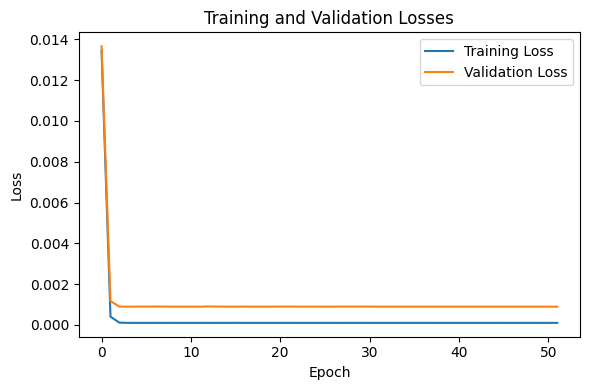

In [ ]:
plot_manager= PlotManager()

# Inside your training loop
plot_manager.plot_losses(trainer.train_losses, trainer.eval_losses)

# After your training loop
plot_manager.show_plots()

In [ ]:
# https://towardsdatascience.com/the-math-behind-lstm-9069b835289d
# https://medium.com/@wangdk93/lstm-from-scratch-c8b4baf06a8b

# PyTorch version

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [7]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# https://medium.com/we-talk-data/time-series-forecasting-with-pytorch-c18fc512daf4

With look_back=1, it is quite surely that the accuracy would not be good for too little clues to predict. But this is a good example to demonstrate the structure of the LSTM model.

In [8]:
# instantiate the dataset
data= TimeSeriesData('2010-1-1', '2020-12-31', look_back=1)
Xtr, Ytr, Xte, Yte= data.split_train_test(PATH)

# reshape input to be [samples, time steps, features]
Xtr= np.reshape(Xtr, (Xtr.shape[0], Xtr.shape[1], 1))
Xte= np.reshape(Xte, (Xte.shape[0], Xte.shape[1], 1))

Xtr= torch.tensor(Xtr, requires_grad=True).type(torch.float32).to(device)
Ytr= torch.tensor(Ytr.squeeze(axis=-1)).type(torch.float32).to(device)
Xte= torch.tensor(Xte, requires_grad=True).type(torch.float32).to(device)
Yte= torch.tensor(Yte.squeeze(axis=-1)).type(torch.float32).to(device)

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([1728, 1, 1]), Ytr - torch.Size([1728, 1])
Shape of test data: Xte - torch.Size([851, 1, 1]), Yte - torch.Size([851, 1])


In this model, input_size refers to the number of features in each time step, hidden_size dictates the dimensionality of the hidden states, and output_size is typically set to 1 for univariate forecasting. This configuration ensures you have a versatile LSTM model ready to tackle various forecasting tasks.

In [9]:
class Py_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers=1,
                 dropout=0.1) -> None:
        super(Py_LSTM, self).__init__()
        self.hidden_size= hidden_size
        self.num_lstm_layers= num_lstm_layers

        lstm_dropout= dropout if num_lstm_layers> 1 else 0.0

        self.lstm= nn.LSTM(
            input_size, hidden_size, num_lstm_layers, batch_first=True, dropout=lstm_dropout
        )
        self.activ1= nn.ReLU()
        self.fc_in = nn.Linear(hidden_size, int(hidden_size / 2))
        self.activ2= nn.ReLU()
        self.dropout= nn.Dropout(p=dropout)
        self.fc_out= nn.Linear(int(hidden_size / 2), output_size)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.xavier_normal_(p)


    def forward(self, x):
        h_0= torch.zeros( # initialize hidden state with zeros
            (self.num_lstm_layers, x.shape[0], self.hidden_size), requires_grad=True, device=x.device
        )
        c_0= torch.zeros( # initialize cell state with zeros
            (self.num_lstm_layers, x.shape[0], self.hidden_size), requires_grad=True, device=x.device
        )
        # propagate input (hidden and internal state) through LSTM
        lstm_out, (h_n, c_n)= self.lstm(x, (h_0, c_0))
        # decode the output from the last LSTM cell
        lstm_out= lstm_out[:, -1, :]
        x= self.activ1(lstm_out)
        x= self.fc_in(x)
        x= self.activ2(x)
        x= self.dropout(x)
        x= self.fc_out(x)

        return x


In [10]:
input_size= 1    # number of features
hidden_size= 256 # number of LSTM units
output_size= 1   # dimensionality of the output space (classes)
num_layers= 1    # number of stacked lstm layers

model= Py_LSTM(input_size, hidden_size, output_size, num_layers).to(device)

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model

Number of parameters: 298241


Py_LSTM(
  (lstm): LSTM(1, 256, batch_first=True)
  (activ1): ReLU()
  (fc_in): Linear(in_features=256, out_features=128, bias=True)
  (activ2): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
def supervised_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                        batch_size=64, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.MSELoss()

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    test_hist= []

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []

        # iterating over all batches
        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[(i * batch_size) : ((i+1) * batch_size)]
            Ymb= Ytr[(i * batch_size) : ((i+1) * batch_size)]

            # --- forward pass and get loss ---
            model.train(True)
            y_pred= model(Xmb)
            loss_tr= loss_fn(y_pred.view(Ymb.shape), Ymb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_pred= model(Xte)
                loss_te= loss_fn(y_pred.view(Yte.shape), Yte)

        test_hist.append(loss_te.item())


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, test_hist


In [12]:
input_size= 1    # number of features
hidden_size= 256 # number of LSTM units
output_size= 1   # dimensionality of the output space (classes)
num_layers= 1    # number of stacked lstm layers

model= Py_LSTM(input_size, hidden_size, output_size, num_layers).to(device)

train_hist, test_hist= supervised_training(model, learning_rate=1e-3, epochs=500,
                                           eval_interval=5, batch_size=256, cutoff=1e-6)

100%|██████████| 500/500 [00:11<00:00, 45.00it/s]


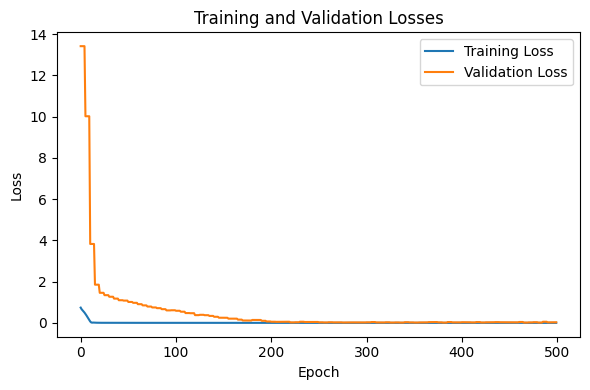

In [13]:
plot_manager= PlotManager()
# Inside your training loop
plot_manager.plot_losses(train_hist, test_hist)
# After your training loop
plot_manager.show_plots()

We can plot the predictions on the data set, to check out how the model is performing. But before performing predictions on the whole dataset, we'll need to bring the original dataset into the model suitable format, which can be done by using similar code as above.

We can simply perform predictions on the whole dataset via a forward pass, and then to plot them, converting them to numpy, reversing transform them (remember that we scaled the data, and we'll need to reverse transform it) and then plot it.

In [ ]:
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# https://cnvrg.io/pytorch-lstm/

# Visualizing Predictions vs. Actual

This plot will help you see patterns where the model may have over or under-predicted. Consistent deviations often signal areas where the model can be improved, such as by tuning hyperparameters or using more complex architectures.

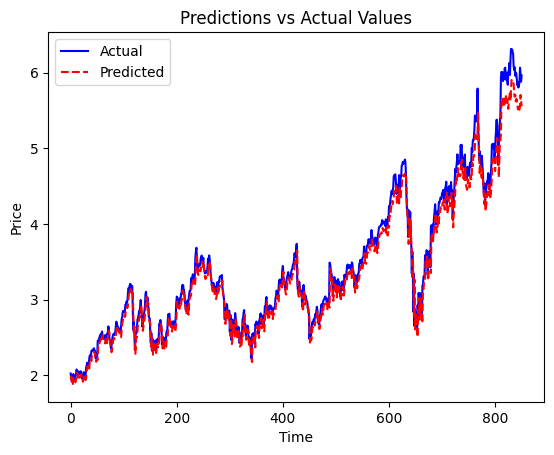

In [14]:
model.eval()
y_pred= model(Xte)
y_pred= y_pred.view(Yte.shape).cpu().detach().numpy()

# Plotting predictions vs actual values
plt.plot(Yte.cpu(), label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
plt.title("Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Residual Analysis

Residuals, or the difference between actual and predicted values, can reveal model biases and data issues.

If your residuals are randomly scattered around zero, you're in good shape. Patterns or clusters, however, indicate that your model might be underfitting or overfitting certain patterns in the data, which you can address with further tuning or by exploring more advanced architectures.

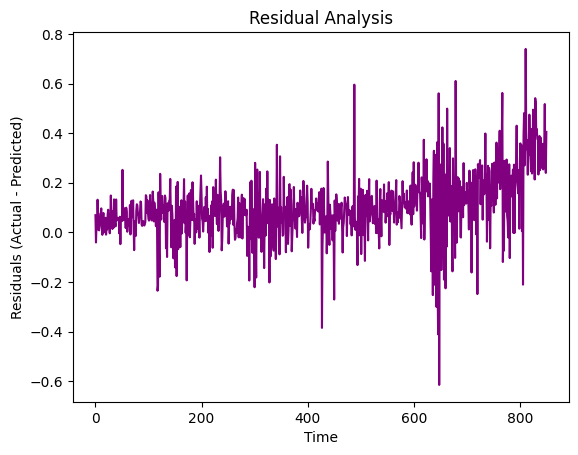

In [15]:
# Calculate residuals
residuals= Yte.cpu() - y_pred

# Plot residuals
plt.plot(residuals, color="purple")
plt.title("Residual Analysis")
plt.xlabel("Time")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()